# Get MovieLens 25M dataset

In [ ]:
MOVIELENS_URL = "http://files.grouplens.org/datasets/movielens/ml-25m.zip"

In [ ]:
import os

!mkdir /opt/project-storage
!wget $MOVIELENS_URL -O /opt/project-storage/ml-25m.zip

--2020-11-29 06:09:57--  http://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘/opt/project-storage/ml-25m.zip’

/opt/project-storag 100%[===================>] 249.84M  26.6MB/s    in 10s     

2020-11-29 06:10:08 (24.7 MB/s) - ‘/opt/project-storage/ml-25m.zip’ saved [261978986/261978986]



In [ ]:
!ls -l /opt/project-storage/ml-25m.zip
!mkdir /opt/project-storage/data
!ls -l /opt/project-storage/data

-rw-r--r-- 1 root root 261978986 Dec  3  2019 /opt/project-storage/ml-25m.zip
total 0


In [ ]:
# !unzip /opt/project-storage/ml-25m.zip -d /opt/project-storage
!cd /opt/project-storage/ && unzip ml-25m.zip > /dev/null

In [ ]:
!ls -l /opt/project-storage/ml-25m
!df -h

total 1129588
-rw-rw-r-- 1 root root 435164157 Nov 21  2019 genome-scores.csv
-rw-rw-r-- 1 root root     18103 Nov 21  2019 genome-tags.csv
-rw-rw-r-- 1 root root   1368578 Nov 21  2019 links.csv
-rw-rw-r-- 1 root root   3038099 Nov 21  2019 movies.csv
-rw-rw-r-- 1 root root 678260987 Nov 21  2019 ratings.csv
-rw-rw-r-- 1 root root     10460 Nov 21  2019 README.txt
-rw-rw-r-- 1 root root  38810332 Nov 21  2019 tags.csv
Filesystem      Size  Used Avail Use% Mounted on
overlay         148G   34G  114G  23% /
tmpfs            64M     0   64M   0% /dev
tmpfs            13G     0   13G   0% /sys/fs/cgroup
shm              13G     0   13G   0% /dev/shm
/dev/sda1       154G   35G  119G  23% /opt/bin
tmpfs            13G   16K   13G   1% /var/colab
tmpfs            13G     0   13G   0% /proc/acpi
tmpfs            13G     0   13G   0% /proc/scsi
tmpfs            13G     0   13G   0% /sys/firmware


# Read the MovieLens data into Pandas dataframe

In [ ]:
import pandas as pd

ratings_df = pd.read_csv('/opt/project-storage/ml-25m/ratings.csv')
# ratings_df = ratings_df[ratings_df['rating'] >= 3]
NUM_MOVIES = ratings_df['movieId'].nunique()
print("No. of movies:", NUM_MOVIES)

No. of movies: 59047


In [ ]:
TOP_K = 10

In [ ]:
movies_df = pd.read_csv('/opt/project-storage/ml-25m/movies.csv')
movies_df['year'] = movies_df['title'].str.extract("\((\d{4})\)", expand=True)
print(movies_df.count())

# year_movies_count_df = movies_df[['movieId', 'year']].groupby('year').count()
# print(year_movies_count_df)

year_list = sorted(movies_df['year'].dropna().unique())
# print(pd.unique(movies_df['year']).tolist())

avg_ratings_df = ratings_df[['movieId', 'rating']].groupby('movieId').mean()
avg_ratings_year_df = pd.merge(movies_df[['movieId', 'year']], avg_ratings_df, on='movieId', how='left')
avg_ratings_year_df.dropna(inplace=True)

def get_movie_year(movie_id):
  return movies_df[movies_df['movieId'] == movie_id].reset_index(drop=True).at[0, 'year']

def get_movie_title(movie_id):
  return movies_df[movies_df['movieId'] == movie_id].reset_index(drop=True).at[0, 'title']

def predictions(movie_ids):
  recent_movie_year = get_movie_year(movie_ids[-1])
  
  # avg_ratings_movie_year_df = avg_ratings_year_df[(avg_ratings_year_df['year'] == year) & (avg_ratings_year_df['movieId'] != movie_id)]
  avg_ratings_movie_year_df = avg_ratings_year_df[(avg_ratings_year_df['year'] == recent_movie_year) & (np.logical_not(avg_ratings_year_df['movieId'].isin(movie_ids)))]
  top_avg_ratings = avg_ratings_movie_year_df.sort_values(by='rating', ascending=False)
  all_predictions = top_avg_ratings.reset_index(drop=True)
  topK_predictions = all_predictions['movieId'][:TOP_K]
  
  return topK_predictions.tolist()

# year_preds = dict()
# for year in year_list:
#   year_preds[year] = predictions(year)

# year_preds = { year: predictions(movie_id, year) for year in year_list }

# import pprint as pp
# pp.pprint(year_preds)

movie_id = 2
movie_year = get_movie_year(movie_id)
movies_df.head()

movieId    62423
title      62423
genres     62423
year       62013
dtype: int64


,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


# Sort ratings data according to the timestamp column

In [ ]:
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df.sort_values('timestamp', inplace=True)

ratings_df.head()

,userId,movieId,rating,timestamp
326761,2262,21,3.0,1995-01-09 11:46:49
326810,2262,1079,3.0,1995-01-09 11:46:49
326767,2262,47,5.0,1995-01-09 11:46:49
15845015,102689,1,4.0,1996-01-29 00:00:00
15845023,102689,39,5.0,1996-01-29 00:00:00


In [ ]:
print("The shape of the ratings data is", ratings_df.shape)

The shape of the ratings data is (25000095, 4)


# Remove user and items that appears in too few interactions

In [ ]:
import numpy as np
print('Removing inactive users and rare items...')

min_user_activity = 20
min_item_popularity = 100

user_activity = ratings_df.groupby('userId').size()
ratings_df = ratings_df[np.isin(ratings_df.userId, user_activity[user_activity >= min_user_activity].index)]

item_popularity = ratings_df.groupby('movieId').size()
ratings_df = ratings_df[np.isin(ratings_df.movieId, item_popularity[item_popularity >= min_item_popularity].index)]

user_activity = ratings_df.groupby('userId').size()
ratings_df = ratings_df[np.isin(ratings_df.userId, user_activity[user_activity >= min_user_activity].index)]

Removing inactive users and rare items...


In [ ]:
print("The shape of the ratings data is", ratings_df.shape)

NUM_MOVIES = ratings_df['movieId'].nunique()
print("No. of movies:", NUM_MOVIES)

The shape of the ratings data is (24434952, 4)
No. of movies: 10326


# Convert MovieLens movie ids to new movie ids to reduce the number of categories to train the model

In [ ]:
rev_movie_index = dict(enumerate(set(ratings_df['movieId']), start=0))
i = 0
print(len(rev_movie_index.keys()))

# Peek new movie ids
movie_index = { v: k for k, v in rev_movie_index.items() }
for key, val in movie_index.items():
  print(f"{key}: {val}")
  i += 1

  if i == 5:
    break

10326
1: 0
2: 1
3: 2
4: 3
5: 4


# Randomly split by users into training, validation, and test sets using a 60-20-20 split

In [ ]:
TEST_SPLIT = 0.2

no_users = ratings_df['userId'].nunique()
no_val_users = round(TEST_SPLIT * no_users)
no_test_users = round(TEST_SPLIT * no_users)

if no_users <= no_val_users + no_test_users:
  raise ValueError('Choose different validation and test splits')

def extract_n_users(df, n):
  users_ids = np.random.choice(df['userId'].unique(), n)
  n_set = df[df['userId'].isin(users_ids)]
  remain_set = df.drop(n_set.index)
  return n_set, remain_set

print('Splitting data into training, validation and test sets...')
test_set, tmp_set = extract_n_users(ratings_df, no_test_users)
val_set, train_set = extract_n_users(tmp_set, no_val_users)

Splitting data into training, validation and test sets...


In [ ]:
print("Unique Users Count")
print("------------------")
print("Train Set:", train_set['userId'].nunique())
print("Validation Set:", val_set['userId'].nunique())
print("Test Set:", test_set['userId'].nunique())

print("\nRating Rows Count")
print("-----------------")
print("Train Set:", train_set.shape[0])
print("Validation Set:", val_set.shape[0])
print("Test Set:", test_set.shape[0])

Unique Users Count
------------------
Train Set: 103862
Validation Set: 28835
Test Set: 29368

Rating Rows Count
-----------------
Train Set: 15553621
Validation Set: 4393088
Test Set: 4488243


# Generates sequences of user actions from data
# Each sequence has the format [user_id, first_item_id, first_item_rating, 2nd_item_id, 2nd_item_rating, ...]

In [ ]:
def gen_sequences(data):
  data = data.sort_values('userId', kind="mergesort")
  seq = []
  prev_id = -1
  for user_id, item_id, rating in zip(data['userId'], data['movieId'], data['rating']):
    if user_id != prev_id:
      if len(seq) > 3:
        yield seq
      prev_id = user_id
      seq = [user_id]
    seq.extend([item_id, rating])
  yield seq

In [ ]:
import os
data_path = "/opt/project-storage/data"

# Save data in sequences format

In [ ]:
print('Saving the training set in the sequences format...')
with open(os.path.join(data_path, "train_set_sequences"), "w") as file:
  for s in gen_sequences(train_set):
    file.write(' '.join(map(str, s)) + "\n")

print('Saving the validation set in the sequences format...')
with open(os.path.join(data_path, "val_set_sequences"), "w") as file:
  for s in gen_sequences(val_set):
    file.write(' '.join(map(str, s)) + "\n")

print('Saving the test set in the sequences format...')
with open(os.path.join(data_path, "test_set_sequences"), "w") as file:
  for s in gen_sequences(test_set):
    file.write(' '.join(map(str, s)) + "\n")

Saving the training set in the sequences format...
Saving the validation set in the sequences format...
Saving the test set in the sequences format...


In [ ]:
!ls -l $data_path

total 216268
-rw-r--r-- 1 root root  40707875 Nov 29 06:11 test_set_sequences
-rw-r--r-- 1 root root 140925065 Nov 29 06:11 train_set_sequences
-rw-r--r-- 1 root root  39820133 Nov 29 06:11 val_set_sequences


# Sequence generator function

In [ ]:
def seq_generator(file_path):
  min_length = 2
  max_length = None
  lines = []
  
  with open(file_path, 'r') as file:
    for sequence in file:
      lines.append(sequence)

  for j, sequence in enumerate(lines):
    # Express sequence as a list of tuples (movie_id, rating)
    sequence = sequence.split()
    user_id = sequence[0]
    sequence = sequence[1:]
    sequence = [[int(sequence[2*i]), float(sequence[2*i + 1])] for i in range(int(len(sequence) / 2))]

    # Determine length of the sequence to be returned????
    if max_length == None:
      this_max_length = len(sequence)
    else:
      this_max_length = max_length

    if len(sequence) < min_length:
      continue

    length = min(this_max_length, len(sequence))

    # Extract subsequence if needed
    start = np.random.randint(0, len(sequence) - length + 1)
    sequence = sequence[start: start + length]

    yield user_id, sequence

In [ ]:
train_seq_gen = seq_generator(os.path.join(data_path, "train_set_sequences"))
val_seq_gen = seq_generator(os.path.join(data_path, "val_set_sequences"))
test_seq_gen = seq_generator(os.path.join(data_path, "test_set_sequences"))

In [ ]:
print("No. of movies:", NUM_MOVIES)

def vectorize_sequences(sequences, dimensions=10000):
    results = np.zeros((len(sequences), dimensions))
    for i, sequence in enumerate(sequences):
      movie_id = movie_index[sequence[0]]
      results[i, movie_id] = 1.
    return results

def vectorize_seq(item):
  item_id, rating = item

  result = np.zeros(NUM_MOVIES)
  movie_id = movie_index[item_id]
  result[movie_id] = 1.

  return np.concatenate((result, get_ratings_features(item)))

def get_ratings_features(item):
    # Get the "other features" of an item, i.e. [personal_rating on a scale of ten, average_rating on a scale of ten, popularity on a log scale of ten]
    
    def int2list(val, length):
      f = np.zeros(length)
      f[int(val) - 1] = 1
      return f

    item_id, rating = item
    rating = int2list(round(rating*2), 10)
    return rating

No. of movies: 10326


# Mini-batch generator function

In [ ]:
import random
# from keras.utils.np_utils import to_categorical

# Mini-batch generator
def mini_batch_generator(seq_generator, min_range=2, batch_size=10, max_length=200, test=False, eval_test=False):
  while True:
    i = 0
    samples = []
    targets = []
    
    while i < batch_size:
      user_id, sequence = next(seq_generator)

      # Generate random sequence lengths
      if not test:
        seq_lengths = sorted(random.sample(range(min_range, len(sequence)), min(batch_size - i, len(sequence) - 2)))
      else:
        seq_lengths = [int(len(sequence) / 2)]

      skipped_seq = 0
      for seq_len in seq_lengths:
        target = sequence[seq_len:]
        if len(target) == 0:
          skipped_seq += 1
          continue
        start = max(0, seq_len - max_length)
        samples.append(sequence[start: seq_len])
        targets.append(target[0])

      i += len(seq_lengths) - skipped_seq

    if eval_test:
      yield samples, targets
      
    else:
      train_X = np.zeros((len(samples), max_length, NUM_MOVIES+10))
      for j, sample in enumerate(samples):
        seq_features = list(map(lambda x: vectorize_seq(x), sample))
        train_X[j, :len(sample), :] = seq_features

      train_Y = vectorize_sequences(targets, dimensions=NUM_MOVIES)
      
      yield train_X, train_Y

In [ ]:
BATCH_SIZE = 128
MAX_LENGTH = 10
NEURONS = 128

# Evaluate the naive method

In [ ]:
import pprint as pp
test_naive_gen = mini_batch_generator(test_seq_gen, batch_size=BATCH_SIZE, max_length=MAX_LENGTH, test=True, eval_test=True)
test_steps = 100
#
def evaluate_naive_method():
  score = 0
  samples_len = 0
  
  print("Calulating Naive TopKCategoricalAccuracy...")
  for step in range(test_steps):
    print("Test Steps:", step)
    samples, targets = next(test_naive_gen)
    # pp.pprint(samples)
    
    # key_error_count = 0
    for j, sample in enumerate(samples):
      # recent_movie_id = sample[-1][0]
      movie_ids = [ movie_id[0] for movie_id in sample ]
      movie_target = targets[j]
      # movie_year = get_movie_year(recent_movie_id)

      score += int(movie_target[0] in predictions(movie_ids))

    samples_len += len(samples)

  k_accuracy = score / samples_len
  print(f"TopKCategoricalAccuracy: {k_accuracy*100:.2f}%")

evaluate_naive_method()

Calulating Naive TopKCategoricalAccuracy...
Test Steps: 0
Test Steps: 1
Test Steps: 2
Test Steps: 3
Test Steps: 4
Test Steps: 5
Test Steps: 6
Test Steps: 7
Test Steps: 8
Test Steps: 9
Test Steps: 10
Test Steps: 11
Test Steps: 12
Test Steps: 13
Test Steps: 14
Test Steps: 15
Test Steps: 16
Test Steps: 17
Test Steps: 18
Test Steps: 19
Test Steps: 20
Test Steps: 21
Test Steps: 22
Test Steps: 23
Test Steps: 24
Test Steps: 25
Test Steps: 26
Test Steps: 27
Test Steps: 28
Test Steps: 29
Test Steps: 30
Test Steps: 31
Test Steps: 32
Test Steps: 33
Test Steps: 34
Test Steps: 35
Test Steps: 36
Test Steps: 37
Test Steps: 38
Test Steps: 39
Test Steps: 40
Test Steps: 41
Test Steps: 42
Test Steps: 43
Test Steps: 44
Test Steps: 45
Test Steps: 46
Test Steps: 47
Test Steps: 48
Test Steps: 49
Test Steps: 50
Test Steps: 51
Test Steps: 52
Test Steps: 53
Test Steps: 54
Test Steps: 55
Test Steps: 56
Test Steps: 57
Test Steps: 58
Test Steps: 59
Test Steps: 60
Test Steps: 61
Test Steps: 62
Test Steps: 63
Test S

In [ ]:
train_gen = mini_batch_generator(train_seq_gen, batch_size=BATCH_SIZE, max_length=MAX_LENGTH)
val_gen = mini_batch_generator(val_seq_gen, batch_size=BATCH_SIZE, max_length=MAX_LENGTH)

test_seq_gen = seq_generator(os.path.join(data_path, "test_set_sequences"))
test_gen = mini_batch_generator(test_seq_gen, batch_size=BATCH_SIZE, max_length=MAX_LENGTH, test=True)

# Train the model

In [ ]:
from keras.layers import Dense, LSTM, GRU
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras import layers
from keras.metrics import TopKCategoricalAccuracy
import time

model = Sequential()
model.add(layers.Masking(mask_value=0, input_shape=(MAX_LENGTH, NUM_MOVIES+10)))
# model.add(layers.GRU(NEURONS))
model.add(layers.Bidirectional(layers.GRU(NEURONS)))
model.add(layers.Dense(NUM_MOVIES, activation='softmax'))
model.summary()

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=[TopKCategoricalAccuracy(k=TOP_K)])
start_time = time.time()
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=100)
end_time = time.time()
exec_time = round(end_time - start_time, 3)
print(f"Total Execution Time: {exec_time}s")

results = model.evaluate(test_gen)
print(results)
print("The test top-k accuracy is {:.2f}%".format(results[1]*100))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_3 (Masking)          (None, 10, 10336)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               8037888   
_________________________________________________________________
dense_3 (Dense)              (None, 10326)             2653782   
Total params: 10,691,670
Trainable params: 10,691,670
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 52s 104ms/step - loss: 7.3599 - top_k_categorical_accuracy: 0.0835 - val_loss: 6.9313 - val_top_k_categorical_accuracy: 0.1256
Epoch 2/20
500/500 [==============================] - 52s 104ms/step - loss: 6.7279 - top_k_categorical_accuracy: 0.1446 - val_loss: 6.7507 - val_top_k_categorical_accuracy: 0.1482
Epoch 3/20

# Visualize the training and validation accuracy

dict_keys(['loss', 'top_k_categorical_accuracy', 'val_loss', 'val_top_k_categorical_accuracy'])


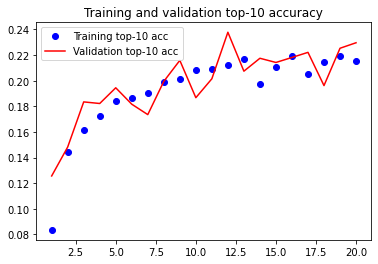

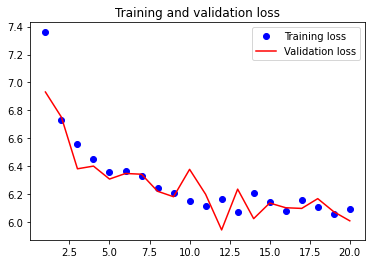

In [ ]:
print(history.history.keys())

import matplotlib.pyplot as plt

def plot_acc_loss(history):
  history_dict = history.history

  acc = history_dict['top_k_categorical_accuracy']
  val_acc = history_dict['val_top_k_categorical_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label=f'Training top-{TOP_K} acc')
  plt.plot(epochs, val_acc, 'r', label=f'Validation top-{TOP_K} acc')
  plt.title(f'Training and validation top-{TOP_K} accuracy')
  plt.legend()

  plt.savefig("best_model_acc.png", dpi=144, format='png')
  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.savefig("best_model_loss.png", dpi=144, format='png')
  plt.show()

plot_acc_loss(history)

In [ ]:
test_seq_gen = seq_generator(os.path.join(data_path, "test_set_sequences"))
test_gen = mini_batch_generator(test_seq_gen, batch_size=BATCH_SIZE, max_length=MAX_LENGTH, test=True, eval_test=True)

# Evaluate different metrics

In [ ]:
from scipy.stats import rankdata

def top_k_recommendations(seq, k=10):
  # Recieves a sequence of (id, rating), and produces k recommendations (as a list of ids)
  preds = model.predict(seq)
  rankpos = lambda x: (len(x)+1) - rankdata(x).astype(int)
  ranked_preds = list([rankpos(rec) for rec in preds][0])

  preds_list = []
  for i in range(1, k+1):
    try:
      preds_list.append(ranked_preds.index(i))
    except ValueError:
      continue
  correct_preds_list = [ rev_movie_index[pred] for pred in preds_list ]

  return correct_preds_list


def evaluate_coverage():
  correct_preds = []
  all_preds = []
  user_cov_count = 0
  samples_len = 0

  for step in range(test_steps):
    print("Test Steps:", step)
    samples, targets = next(test_gen)
    
    for j, sample in enumerate(samples):
      test_X = np.zeros((1, MAX_LENGTH, NUM_MOVIES))
      seq_features = list(map(lambda x: vectorize_seq(x), sample))
      test_X[0, :len(sample), :] = seq_features

      top_k_preds = top_k_recommendations(test_X, k=TOP_K)
      # print(top_k_preds)

      target_movie_id = targets[j][0]

      correct_preds.extend(set([target_movie_id]) & set(top_k_preds))
      all_preds.extend(top_k_preds)
      user_cov_count += int(len(set([target_movie_id]) & set(top_k_preds)) > 0)
    
    samples_len += len(samples)
    # break
  
  return len(set(correct_preds)), len(set(all_preds)), (user_cov_count / samples_len)

item_cov, all_cov, user_cov_score = evaluate_coverage()
print("Item Coverage:", item_cov)
print("Recommendations Coverage:", all_cov)
print(f"User Coverage: {user_cov_score*100:.2f}%")

Test Steps: 0


ValueError: ignored

In [ ]:
test_seq_gen = seq_generator(os.path.join(data_path, "test_set_sequences"))
test_gen = mini_batch_generator(test_seq_gen, batch_size=BATCH_SIZE, max_length=MAX_LENGTH, test=True)

# Predict Sample Top-K Movies

In [ ]:
from scipy.stats import rankdata

USER_INDEX = 0

X_test, Y_test = next(test_gen)
print(X_test.shape)
print(Y_test.shape)
print(X_test[USER_INDEX].shape)

print("\nSample Sequence:")
seq_list = []
for seq in X_test[USER_INDEX]:
  try:
    seq_list.append(list(seq).index(1))
  except ValueError:
    continue

# seq_list = [ list(seq).index(1) for seq in X_test[USER_INDEX] ]
correct_seq_list = [ rev_movie_index[seq] for seq in seq_list ]
movie_title_list = [ get_movie_title(movie_id) for movie_id in correct_seq_list ]
pp.pprint(movie_title_list)

target_movie_id = list(Y_test[USER_INDEX]).index(1)
movie_id = rev_movie_index[target_movie_id]
print("\nTarget Movie:", get_movie_title(movie_id))

# preds_list = [ ranked_preds.index(i) for i in range(1, top_k+1) ]
# correct_preds_list = [ rev_movie_index[pred] for pred in preds_list ]

print("\nSample Top-K Predictions:")
X = np.zeros((1, MAX_LENGTH, NUM_MOVIES))
X[0, :, :] = X_test[USER_INDEX]
# model_preds = model.predict(X)
# print(model_preds)
top_k_preds = top_k_recommendations(X, k=TOP_K)
movie_preds = [ get_movie_title(movie_id) for movie_id in top_k_preds ]
pp.pprint(movie_preds)

# Group Recommendations

In [ ]:
from scipy.stats import rankdata

def top_k_recommendations_for_user(USER_INDEX):
  X_test, Y_test = next(test_gen)

  seq_list = []
  for seq in X_test[USER_INDEX]:
    try:
      seq_list.append(list(seq).index(1))
    except ValueError:
      continue

  # seq_list = [ list(seq).index(1) for seq in X_test[USER_INDEX] ]
  correct_seq_list = [ rev_movie_index[seq] for seq in seq_list ]
  movie_title_list = [ get_movie_title(movie_id) for movie_id in correct_seq_list ]
  # pp.pprint(movie_title_list)

  target_movie_id = list(Y_test[USER_INDEX]).index(1)
  movie_id = rev_movie_index[target_movie_id]

  # preds_list = [ ranked_preds.index(i) for i in range(1, top_k+1) ]
  # correct_preds_list = [ rev_movie_index[pred] for pred in preds_list ]

  # print("\nSample Top-K Predictions:")
  X = np.zeros((1, MAX_LENGTH, NUM_MOVIES))
  X[0, :, :] = X_test[USER_INDEX]
  # model_preds = model.predict(X)
  # print(model_preds)
  top_k_preds = top_k_recommendations(X, k=TOP_K)
  movie_preds = [ get_movie_title(movie_id) for movie_id in top_k_preds ]
  # pp.pprint(movie_preds)
  return correct_seq_list, top_k_preds

def avg_movie_rating(movie_id):
  return avg_ratings_df[avg_ratings_df['movieId'] == movie_id].reset_index(drop=True).at[0, 'rating']

USER_1 = 0
USER_2 = 1
USER_3 = 2

seq_1, preds_1 = top_k_recommendations_for_user(USER_1)
seq_2, preds_2 = top_k_recommendations_for_user(USER_2)
seq_3, preds_3 = top_k_recommendations_for_user(USER_3)

print("Individual Recommendations")
print("\nUser 1:")
movie_preds = [ get_movie_title(movie_id) for movie_id in preds_1 ]
pp.pprint(movie_preds)

print("\nUser 2:")
movie_preds = [ get_movie_title(movie_id) for movie_id in preds_2 ]
pp.pprint(movie_preds)

print("\nUser 3:")
movie_preds = [ get_movie_title(movie_id) for movie_id in preds_3 ]
pp.pprint(movie_preds)

# Create a single list of movies and remove duplicates
seen_movies = []
seen_movies.extend(seq_1)
seen_movies.extend(seq_2)
seen_movies.extend(seq_3)
seen_movies = list(set(seen_movies))

group_movies = []
group_movies.extend(preds_1)
group_movies.extend(preds_2)
group_movies.extend(preds_3)
group_movies = list(set(group_movies))

# Remove seen movies
for seen_movie in seen_movies:
  if seen_movie in group_movies:
    group_movies.remove(seen_movie)

# Rank group recommnedations
avg_ratings_df = ratings_df[['movieId', 'rating']].groupby('movieId').mean()
avg_ratings_df = avg_ratings_df.reset_index()

avg_ratings_list = [ avg_movie_rating(movie_id) for movie_id in group_movies ]
movie_year_list = [ int(get_movie_year(movie_id)) for movie_id in group_movies ]

group_movies_data = {'movieId': group_movies, 'avgRating': avg_ratings_list, 'year': movie_year_list}
group_movies_data_df = pd.DataFrame(data=group_movies_data)

ranked_movies_data_df = group_movies_data_df.sort_values(by=['year', 'avgRating'], ascending=False)
ranked_movies = ranked_movies_data_df['movieId'].tolist()

print("\nGroup Movie Recommendations")
print("---------------------------")
group_movie_preds = [ get_movie_title(movie_id) for movie_id in ranked_movies ]
pp.pprint(group_movie_preds[:min(TOP_K, len(group_movie_preds))])